## Experiment with flight data APIs

Initial goal: compare deterministic optimal (cheapest) flight search to agent-driven one

In [44]:
from utils.utils import get_flights_to_destinations, plot_price_distribution

import nest_asyncio
nest_asyncio.apply()

import json
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()
import os

from openai import AsyncOpenAI
from openai.types.responses import ResponseTextDeltaEvent
client = AsyncOpenAI()
from agents import Agent, Runner, ItemHelpers, function_tool, ModelSettings, WebSearchTool

from IPython.display import Markdown, display

import warnings
warnings.filterwarnings("ignore")

Test query with the function

In [2]:
flights_df = get_flights_to_destinations(
    date="2025-05-02",
    from_airport="EWR",
    to_airports=[
        "ORY",  # Orly
        "CDG",  # Charles de Gaulle
    ],
    max_stops=1,
    #trip="one-way",
    #passengers_adults=2,
)

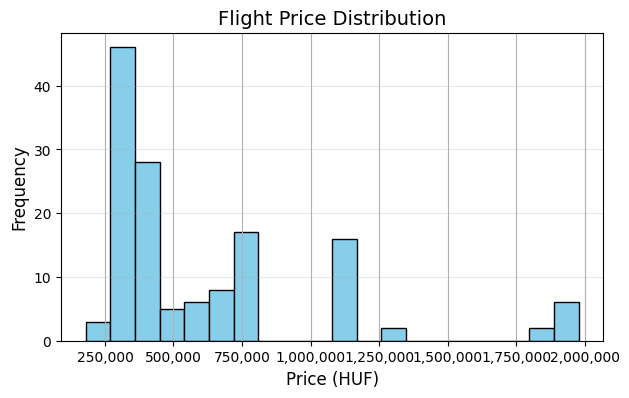

In [3]:
fig = plot_price_distribution(flights_df)

In [4]:
pd.DataFrame(flights_df['name'].value_counts())

,count
name,
Tap Air Portugal,32
Delta,20
"Delta, Air France",14
United,10
"United, Tap Air Portugal",6
Air Canada,6
Turkish Airlines,5
Lufthansa,5
British Airways,4


In [5]:
flights_df.head(3)

,price,departure_date,departure_time,arrival_date,arrival_time,duration_hours,name,stops,is_best,price_denomination
0,179192,2025-05-02,23:00,2025-05-03,12:15,7.250,French bee,0,True,HUF
1,407143,2025-05-02,20:25,2025-05-03,21:55,19.500,Self transferThis trip includes tickets from m...,1,True,HUF
2,601424,2025-05-02,20:20,2025-05-03,19:25,17.083,LOT,1,True,HUF


### General tool-calling agent

Showcasing tool calling capabilities by assigning the above function as a tool to an OpenAI model. Tool will return with the pandas under the hood, the AI will analyze the content and provide an answer

1. Set up custom tool

In [21]:
from utils.utils import get_flights_to_destinations_tool

# add test tool for quick testing
@function_tool
async def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

2. Set up OpenAI responses API wrapper

In [63]:
system_message = "You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability."

user_message_template = """
<current_datetime>
The current date and time is {current_datetime}.
</current_datetime>

<instructions>
Your sole purpose is to answer user's questions. You aim to be informative and helpful, providing concise but complete answers. The user may ask you any questions. For general questions, use your own knowledge. For flight information, use the available tools.

When answering about flights, be thorough in your response. Include information about the price distribution, offer a few different options across various airlines and times, and highlight the best deal based on price and convenience. Mention both the cheapest options and any premium alternatives that might provide better value.
</instructions>

<user_question>
{question}
</user_question>
"""

async def ai(question: str, tools=[get_flights_to_destinations_tool, add], stream=False, model="gpt-4.1"):
    
    current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M')
    
    agent = Agent(
        name="Flight Assistant",
        instructions=system_message,
        model=model,
        tools=tools,
    )
    
    formatted_question = user_message_template.format(
        question=question,
        current_datetime=current_datetime
    )
    
    if stream:
        result = Runner.run_streamed(agent, formatted_question)

        #print("=== Run starting ===")
        async for event in result.stream_events():

            if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
                print(event.data.delta, end="", flush=True)

            elif event.type == "agent_updated_stream_event":
                #print(f"Agent updated: {event.new_agent.name}")
                continue

            elif event.type == "run_item_stream_event":
                if event.item.type == "tool_call_item":
                    tool_name = event.item.raw_item.name
                    tool_args = event.item.raw_item.arguments
                    print(f"Tool {tool_name} called with arguments: {tool_args}")

                elif event.item.type == "tool_call_output_item":
                    tool_name = event.item.raw_item['call_id'].split('_')[1]
                    tool_output = str(event.item.output)[:250]
                    print(f"Tool call {tool_name} returned with results: {tool_output}")

                #elif event.item.type == "message_output_item":
                #    print("------ Agent output ------")
                #    print(f"{ItemHelpers.text_message_output(event.item)}")
                #    print("------ / Agent output ------")

                else:
                    pass  # Ignore other event types

        #print("=== Run complete ===")

        return result
    else:
        result = await Runner.run(agent, formatted_question)
        return result

Simple test

In [64]:
q = 'first, tell me what 4 + 10 is using the add tool, then tell me what is the difference between declarative and imperative?'
a = await ai(q, stream=True)

Tool add called with arguments: {"a":4,"b":10}
Tool call BVEsZ52qxKL4Yu4Nb2ULqJ5x returned with results: 14
The answer to 4 + 10 is 14.

For your second question: The difference between declarative and imperative programming is primarily in how you express instructions to the computer:

- Declarative programming describes what you want to achieve, not necessarily how to do it. You state the desired outcome, and the underlying system figures out how to achieve it. Examples include SQL for databases ("SELECT name FROM users WHERE age > 25;") or HTML for web pages.

- Imperative programming, on the other hand, involves giving explicit step-by-step instructions on how to achieve a result. You control the flow and state changes directly. Common imperative languages include C, Java, and Python when used in a step-by-step manner.

In summary: Declarative says "what," imperative says "how."

In [65]:
display(Markdown(a.final_output))

The answer to 4 + 10 is 14.

For your second question: The difference between declarative and imperative programming is primarily in how you express instructions to the computer:

- Declarative programming describes what you want to achieve, not necessarily how to do it. You state the desired outcome, and the underlying system figures out how to achieve it. Examples include SQL for databases ("SELECT name FROM users WHERE age > 25;") or HTML for web pages.

- Imperative programming, on the other hand, involves giving explicit step-by-step instructions on how to achieve a result. You control the flow and state changes directly. Common imperative languages include C, Java, and Python when used in a step-by-step manner.

In summary: Declarative says "what," imperative says "how."

Test with flight related question

In [66]:
q = 'what is 5 plus 7, then plus 10?'
a = await ai(q, stream=True)

Tool add called with arguments: {"a":5,"b":7}
Tool call FJoe0WF5Cw4HLy91m5senz5N returned with results: 12
Tool add called with arguments: {"a":12,"b":10}
Tool call g6Wre6mkjCwAWmJ0NgblDtvO returned with results: 22
5 plus 7 is 12, and then adding 10 gives you a total of 22.

In [67]:
display(Markdown(a.final_output))

5 plus 7 is 12, and then adding 10 gives you a total of 22.

In [68]:
a.new_items

[ToolCallItem(agent=Agent(name='Flight Assistant', instructions="You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability.", handoff_description=None, handoffs=[], model='gpt-4.1', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=False, truncation=None, max_tokens=None), tools=[FunctionTool(name='get_flights_to_destinations_tool', description="Fetch flights to multiple destinations and return a combined DataFrame.\n\nNote: The fast_flights API doesn't support multiple destinations in a single call,\nso this function makes separate API calls for each destination and combines the results.", params_json_schema={'properties': {'date': {'description': 'Flight date in YYYY-MM-DD format', 'title': 'Date', 'type': 'string'}, 'from_airport': {'description': 'Departure airpor

In [69]:
a.raw_responses

[ModelResponse(output=[ResponseFunctionToolCall(id='fc_680609b0160c819297290762355425b3014a1a27a5045630', arguments='{"a":5,"b":7}', call_id='call_FJoe0WF5Cw4HLy91m5senz5N', name='add', type='function_call', status='completed')], usage=Usage(requests=1, input_tokens=414, output_tokens=18, total_tokens=432), referenceable_id='resp_680609ae50448192a7a6b06ed6ab0867014a1a27a5045630'),
 ModelResponse(output=[ResponseFunctionToolCall(id='fc_680609b1cf5c81928a3c961691e33460014a1a27a5045630', arguments='{"a":12,"b":10}', call_id='call_g6Wre6mkjCwAWmJ0NgblDtvO', name='add', type='function_call', status='completed')], usage=Usage(requests=1, input_tokens=437, output_tokens=18, total_tokens=455), referenceable_id='resp_680609b07bc88192a2b347e9c2bc1e25014a1a27a5045630'),
 ModelResponse(output=[ResponseOutputMessage(id='msg_680609b30aa481928f33c332b931d023014a1a27a5045630', content=[ResponseOutputText(annotations=[], text='5 plus 7 is 12, and then adding 10 gives you a total of 22.', type='output_t

Complex question

In [43]:
model_for_complex_question = 'o1'

q = 'I want to find the best deal for flying to Madeira from Budapest any time between 2025-07-01 and 2025-07-15. I will want to spend at least 5, at most 8 days there. I will be traveling with my girlfriend. Ideally I only want to have at most 1 stop. Find the optimal flight for me. I want to have the cheapest flight possible.'
a = await ai(q, model=model_for_complex_question)

In [46]:
display(Markdown(a.final_output))

Below is an option that, based on currently available data, yields the lowest total fare (departure on July 1, returning on July 8). This trip length is 6 nights on the ground in Madeira (arriving the morning of July 2 and leaving on July 8), which fits your “5 to 8 days” requirement.

1) Outbound (Budapest → Madeira):
   • Date/Time: Departs Tue, July 1 at 20:00, arrives Wed, July 2 at 09:35  
   • Airline(s): SWISS + Edelweiss Air (1 stop)  
   • Duration: ~14h 35m  
   • Price: 180,800 HUF

2) Return (Madeira → Budapest):
   • Date/Time: Departs Tue, July 8 at 09:50, arrives Wed, July 9 at 07:50  
   • “Self-transfer” itinerary with 1 stop (multiple carriers)  
   • Price: 82,651 HUF

Total Fare (per person): 180,800 + 82,651 = 263,451 HUF  
For two travelers, simply double that amount.

Why this is optimal for a budget:
• Among all combinations checked (departing July 1, returning on different dates between July 6 and July 9 to satisfy 5–8 days), this pairing yields the lowest combined cost.  
• If you prefer fewer stopovers or a shorter travel time, there are single-stop or direct flights with slightly higher fares (for example, returning on July 7 for around 110,000 HUF rather than ~83,000 HUF on July 8). However, they add to the overall ticket price.

If you have flexibility to change departure dates, it is worth checking July 2 or 3 departures as well—sometimes midweek can be cheaper. But with the data at hand, this July 1–8 plan is the least expensive option.

In [44]:
a.new_items

[ReasoningItem(agent=Agent(name='Flight Assistant', instructions="You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability.", handoff_description=None, handoffs=[], model='o1', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=False, truncation=None, max_tokens=None), tools=[FunctionTool(name='get_flights_to_destinations_tool', description="Fetch flights to multiple destinations and return a combined DataFrame.\n\nNote: The fast_flights API doesn't support multiple destinations in a single call,\nso this function makes separate API calls for each destination and combines the results.", params_json_schema={'properties': {'date': {'description': 'Flight date in YYYY-MM-DD format', 'title': 'Date', 'type': 'string'}, 'from_airport': {'description': 'Departure airport co

### Try manual price checks

In [50]:
def find_cheapest_round_trip(
    outbound_date,
    total_travel_time_min,
    total_travel_time_max,
    outbound_date_flexibility,
    from_airport,
    to_airports,
    max_stops=1
):
    """
    Find the cheapest round trip flights based on flexible dates and travel duration.
    
    Args:
        outbound_date (str): Starting date for outbound flight in format 'YYYY-MM-DD'
        total_travel_time_min (int): Minimum number of days for the trip
        total_travel_time_max (int): Maximum number of days for the trip
        outbound_date_flexibility (int): Number of days to check after the outbound date
        from_airport (str): Departure airport code
        to_airports (list): List of destination airport codes
        max_stops (int): Maximum number of stops allowed
        
    Returns:
        tuple: (best_combination_df, all_combinations_df) where:
            - best_combination_df is a DataFrame with the cheapest round trip
            - all_combinations_df is a DataFrame with all combinations tried
    """
    
    # Convert outbound_date to datetime
    outbound_date_dt = datetime.strptime(outbound_date, "%Y-%m-%d")
    
    # Initialize results storage
    all_combinations = []
    
    # Loop through each potential outbound date with tqdm progress bar
    for outbound_offset in tqdm(range(outbound_date_flexibility + 1), desc="Checking outbound dates"):
        current_outbound_date = outbound_date_dt + timedelta(days=outbound_offset)
        current_outbound_str = current_outbound_date.strftime("%Y-%m-%d")
        
        # Get outbound flights
        outbound_flights = get_flights_to_destinations(
            date=current_outbound_str,
            from_airport=from_airport,
            to_airports=to_airports,
            max_stops=max_stops
        )
        
        if outbound_flights.empty:
            continue
            
        # Add direction indicator
        outbound_flights['direction'] = 'outbound'
        
        # Loop through each potential return date based on min/max travel time
        for travel_days in tqdm(range(total_travel_time_min, total_travel_time_max + 1), 
                               desc=f"Checking return dates for outbound {current_outbound_str}", 
                               leave=False):
            return_date = current_outbound_date + timedelta(days=travel_days)
            return_date_str = return_date.strftime("%Y-%m-%d")
            
            # Get return flights
            return_flights = get_flights_to_destinations(
                date=return_date_str,
                from_airport=to_airports[0],  # Assuming the first airport in the list is the main one
                to_airports=[from_airport],
                max_stops=max_stops
            )
            
            if return_flights.empty:
                continue
                
            # Add direction indicator
            return_flights['direction'] = 'return'
            
            # Find cheapest combination
            min_outbound_price = outbound_flights['price'].min()
            min_return_price = return_flights['price'].min()
            total_price = min_outbound_price + min_return_price
            
            # Get the cheapest outbound and return flights
            cheapest_outbound = outbound_flights.loc[outbound_flights['price'] == min_outbound_price].iloc[0]
            cheapest_return = return_flights.loc[return_flights['price'] == min_return_price].iloc[0]
            
            # Combine all flights for this date combination
            combined_flights = pd.concat([outbound_flights, return_flights])
            
            # Store the combination details
            all_combinations.append({
                'outbound_date': current_outbound_str,
                'return_date': return_date_str,
                'travel_days': travel_days,
                'total_price': total_price,
                'outbound_price': min_outbound_price,
                'return_price': min_return_price,
                'cheapest_outbound': cheapest_outbound,
                'cheapest_return': cheapest_return,
                'all_flights': combined_flights
            })
    
    # Convert to DataFrame
    if not all_combinations:
        return pd.DataFrame(), pd.DataFrame()
    
    combinations_df = pd.DataFrame([
        {
            'outbound_date': combo['outbound_date'],
            'return_date': combo['return_date'],
            'travel_days': combo['travel_days'],
            'total_price': combo['total_price'],
            'outbound_price': combo['outbound_price'],
            'return_price': combo['return_price'],
            'outbound_airline': combo['cheapest_outbound']['name'],
            'return_airline': combo['cheapest_return']['name'],
            'outbound_stops': combo['cheapest_outbound']['stops'],
            'return_stops': combo['cheapest_return']['stops'],
            'outbound_duration': combo['cheapest_outbound']['duration_hours'],
            'return_duration': combo['cheapest_return']['duration_hours'],
        }
        for combo in all_combinations
    ])
    
    # Find the cheapest overall combination
    best_combination_idx = combinations_df['total_price'].idxmin()
    best_combination = all_combinations[best_combination_idx]['all_flights']
    
    # Sort combinations by total price
    combinations_df = combinations_df.sort_values('total_price')
    
    return best_combination, combinations_df

In [66]:
# Example usage:
best_flights, all_combinations = find_cheapest_round_trip(
    outbound_date="2025-07-10",
    total_travel_time_min=10,
    total_travel_time_max=16,
    outbound_date_flexibility=30,
    from_airport="BUD",
    to_airports=["JFK", "EWR", "LAX", "SFO"],
    max_stops=2
)

Checking outbound dates: 100%|██████████| 31/31 [09:18<00:00, 18.01s/it]


In [67]:
all_combinations.sort_values(['total_price']).head(10)

,outbound_date,return_date,travel_days,total_price,outbound_price,return_price,outbound_airline,return_airline,outbound_stops,return_stops,outbound_duration,return_duration
59,2025-07-18,2025-07-31,13,454947,291590,163357,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,1,17.917,31.750
56,2025-07-18,2025-07-28,10,457396,291590,165806,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,2,17.917,23.250
47,2025-07-16,2025-07-31,15,463933,300576,163357,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,1,14.583,31.750
44,2025-07-16,2025-07-28,12,466382,300576,165806,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,2,14.583,23.250
207,2025-08-08,2025-08-22,14,467196,320178,147018,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,1,17.917,27.417
195,2025-08-06,2025-08-22,16,468012,320994,147018,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,1,35.167,27.417
61,2025-07-18,2025-08-02,15,468830,291590,177240,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,1,17.917,31.750
57,2025-07-18,2025-07-29,11,468830,291590,177240,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,1,17.917,NaN
203,2025-08-08,2025-08-18,10,474551,320178,154373,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,1,17.917,30.417
43,2025-07-16,2025-07-27,11,475367,300576,174791,Self transferThis trip includes tickets from m...,Self transferThis trip includes tickets from m...,1,2,14.583,18.500
